In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.optimize import fmin_slsqp
from toolz import reduce, partial

In [32]:
attainment = pd.read_excel("nayro.xls")
year_cols = [col for col in attainment.columns if col.startswith('yr')]

rb_codes = ["IL", "IN", "MI", "NY", "OH", "PA", "WV", "WI"]

attainment[year_cols] = attainment[year_cols].notna().astype(int)
attainment[attainment["st_abbr"].isin(rb_codes)]
#counties that have received non-attainment status
tr_counties_codes = attainment["fips_state"].astype(str) + attainment["fips_cnty"].astype(str)
tr_counties = tr_counties_codes.unique()


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'


In [30]:
gdp = pd.read_csv("gdp_components_rust_belt.csv")
gdp["never_treated"] = (~gdp["GeoFIPS"].astype("string").isin(tr_counties)).astype(int)
len(gdp[gdp["never_treated"] == 1]["GeoFIPS"].unique())


556

In [ ]:
gdp_tc = gdp[(gdp["GeoName"] == "Wayne, MI")|(gdp["never_treated"] == 1)]
gdp_tc = gdp_tc.rename(columns={"All industry total": "gdp_all"})

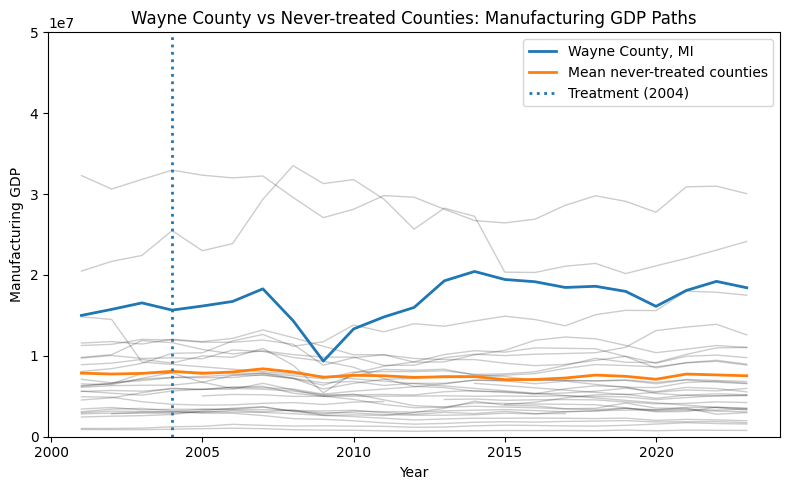

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))


for _, gdf in gdp_tc.groupby("GeoFIPS"):
    ax.plot(gdf["year"], gdf["Manufacturing"], alpha=0.2, lw=1, color="k")


wayne = gdp_tc[gdp_tc["GeoName"] == "Wayne, MI"]
ax.plot(
    wayne["year"],
    wayne["Manufacturing"],
    label="Wayne County, MI",
    lw=2
)

(
    gdp_tc[gdp_tc["never_treated"] == 1]
    .groupby("year")["Manufacturing"]
    .mean()
    .plot(ax=ax, label="Mean never-treated counties", lw=2)
)

ax.set_ylim(0, 0.5e8)

plt.vlines(
    x=2004,
    ymin=0,
    ymax=2e8,
    linestyle=":",
    lw=2,
    label="Treatment (2004)"
)

ax.set_ylabel("Manufacturing GDP")
ax.set_xlabel("Year")
ax.set_title("Wayne County vs Never-treated Counties: Manufacturing GDP Paths")
ax.legend()
plt.tight_layout()
plt.show()


## Synthetic Control (Need fixes)

In [75]:
treat_year = 2004
features = ["gdp_all", "Manufacturing"]  

inverted = (
    gdp_tc.query("year < @treat_year")      
          .pivot(index="GeoName", columns="year")[features]  
          .T                               
)

inverted

GeoName             Albany, NY  Allegheny, PA   Bronx, NY   Bucks, PA  \
              year                                                      
gdp_all       2001  25619736.0     77061648.0  32778255.0  28423449.0   
              2002  25559345.0     77506630.0  33050622.0  29159944.0   
              2003  26341642.0     79627626.0  33340890.0  29558977.0   
Manufacturing 2001   1019314.0      6238963.0    899379.0   4937438.0   
              2002   1022457.0      6562830.0    880898.0   4896216.0   
              2003   1059049.0      7806801.0    873237.0   4323874.0   

GeoName             Chester, PA     Cook, IL  Cuyahoga, OH    Dane, WI  \
              year                                                       
gdp_all       2001   28543104.0  347225458.0    85648399.0  27154378.0   
              2002   29329328.0  344436378.0    86784677.0  28109006.0   
              2003   31852936.0  346429242.0    88529347.0  29134913.0   
Manufacturing 2001    4545371.0   32288451.0    11281089.0   2437315.0   
              2002    4807186.0   30625834.0    11424101.0   2537300.0   
              2003    5437177.0   31814173.0    12034007.0   2604632.0   

GeoName             Delaware, PA  DuPage, IL  ...  Macomb, MI  Marion, IN  \
              year                            ...                           
gdp_all       2001    25774228.0  70747753.0  ...  33423302.0  74232291.0   
              2002    26549102.0  71859837.0  ...  35138244.0  74775750.0   
              2003    27562844.0  73687056.0  ...  36540874.0  76650095.0   
Manufacturing 2001     3088381.0   6527893.0  ...   8900814.0  20480860.0   
              2002     3408742.0   6445529.0  ...   9097623.0  21681959.0   
              2003     3502245.0   7211969.0  ...   9558431.0  22412841.0   

GeoName             Milwaukee, WI  Monroe, NY  Montgomery, PA  Nassau, NY  \
              year                                                          
gdp_all       2001     53673239.0  44331667.0      60772818.0  81131101.0   
              2002     53049884.0  45090157.0      61352479.0  82471351.0   
              2003     53840643.0  45807122.0      64670246.0  84104166.0   
Manufacturing 2001      7103348.0   9722195.0       9812783.0   3424907.0   
              2002      6657049.0  10043771.0      10147577.0   3616382.0   
              2003      7111698.0   9682107.0      11891243.0   3328091.0   

GeoName             New York, NY  Onondaga, NY  Queens, NY   Wayne, MI  
              year                                                      
gdp_all       2001   509411971.0           NaN  75703532.0  95473905.0  
              2002   485937445.0    25241846.0  76063335.0  96211482.0  
              2003   475037039.0    26333748.0  77381547.0  99067192.0  
Manufacturing 2001     5628513.0           NaN   2832317.0  14999631.0  
              2002     5383993.0     2841080.0   2911904.0  15745107.0  
              2003     5139249.0     3021832.0   2911615.0  16545230.0  

[6 rows x 27 columns]

In [73]:
# treated unit = Wayne, MI
X1 = inverted["Wayne, MI"].values               

donor_names = [c for c in inverted.columns if c != "Wayne, MI"]
X0 = inverted[donor_names].values              


def loss_w(W, X0, X1) -> float:
    return np.sqrt(np.mean((X1 - X0.dot(W))**2))


def get_w(X0, X1):
    w_start = [1 / X0.shape[1]] * X0.shape[1]   
    weights = fmin_slsqp(
        partial(loss_w, X0=X0, X1=X1),
        np.array(w_start),
        f_eqcons=lambda x: np.sum(x) - 1,      
        bounds=[(0.0, 1.0)] * len(w_start),    
        disp=False
    )
    return weights

wayne_weights = get_w(X0, X1)


wayne_weights_series = pd.Series(wayne_weights, index=donor_names, name="weight")
print(wayne_weights_series.sort_values(ascending=False))


Albany, NY        0.038462
Allegheny, PA     0.038462
Onondaga, NY      0.038462
New York, NY      0.038462
Nassau, NY        0.038462
Montgomery, PA    0.038462
Monroe, NY        0.038462
Milwaukee, WI     0.038462
Marion, IN        0.038462
Macomb, MI        0.038462
Lehigh, PA        0.038462
Lake, IL          0.038462
Kings, NY         0.038462
Kent, MI          0.038462
Hamilton, OH      0.038462
Franklin, OH      0.038462
Erie, NY          0.038462
DuPage, IL        0.038462
Delaware, PA      0.038462
Dane, WI          0.038462
Cuyahoga, OH      0.038462
Cook, IL          0.038462
Chester, PA       0.038462
Bucks, PA         0.038462
Bronx, NY         0.038462
Queens, NY        0.038462
Name: weight, dtype: float64


In [77]:
donor_panel = (
    gdp_tc.query('GeoName != "Wayne, MI"')
          .pivot(index="year", columns="GeoName")["gdp_all"]
          .sort_index()
)

donor_panel = donor_panel[donor_names]

wayne_synth = donor_panel.values.dot(wayne_weights)

wayne_actual = (
    gdp_tc[gdp_tc["GeoName"] == "Wayne, MI"]
    .sort_values("year")
    .set_index("year")["gdp_all"]
)

years = donor_panel.index  


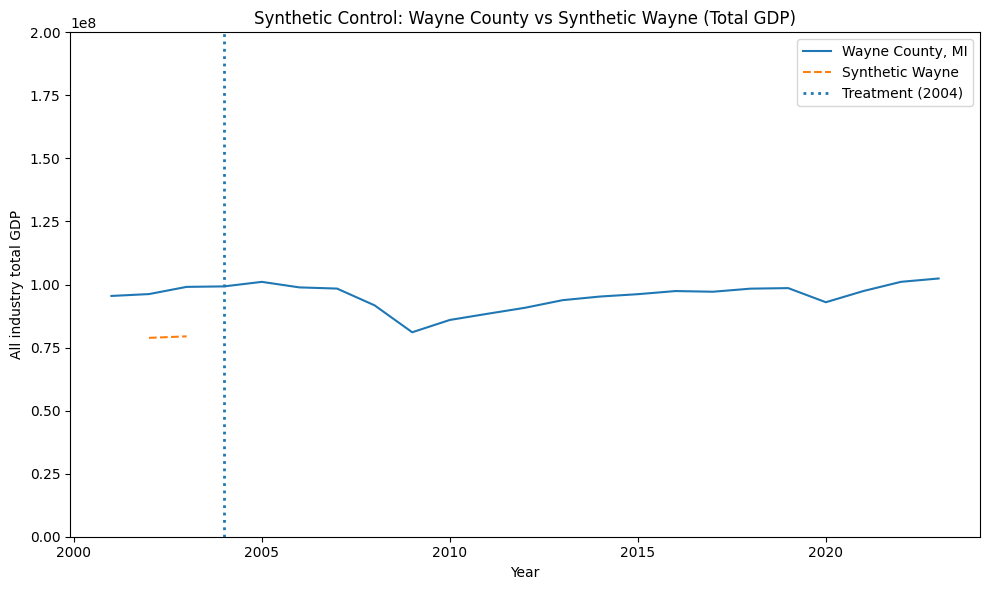

In [70]:
plt.figure(figsize=(10, 6))

plt.plot(wayne_actual.index, wayne_actual.values, label="Wayne County, MI")
plt.plot(years, wayne_synth, label="Synthetic Wayne", linestyle="--")

plt.vlines(x=treat_year, ymin=0, ymax=2e8, linestyle=":", lw=2, label="Treatment (2004)")
plt.ylim(0, 2e8)

plt.ylabel("All industry total GDP")
plt.xlabel("Year")
plt.title("Synthetic Control: Wayne County vs Synthetic Wayne (Total GDP)")
plt.legend()
plt.tight_layout()
plt.show()
